In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

import MathOptInterface as MOI
import Ipopt 
import ForwardDiff as FD 
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Printf

  Activating project at `c:\Users\faust\Desktop\optimal_ctrl_25\HW3_S25_Solutions`


# Q2: iLQR (30 pts)

In this problem, we are going to use iLQR to solve a trajectory optimization for a 6DOF quadrotor. This problem we will use a cost function to motivate the quadrotor to follow a specified aerobatic manuever. The continuous time dynamics of the quadrotor are detailed in `quadrotor.jl`, with the state being the following:

$x = [r,v,{}^Np^B{},\omega]$ where $r\in\mathbb{R}^3$ is the position of the quadrotor in the world frame (N), $v\in\mathbb{R}^3$ is the velocity of the quadrotor in the world frame (N),  $^Np^B\in\mathbb{R}^3$ is the Modified Rodrigues Parameter (MRP) that is used to denote the attitude of the quadrotor, and  $\omega\in\mathbb{R}^3$ is the angular velocity of the quadrotor expressed in the body frame (B).  By denoting the attitude of the quadrotor with a MRP instead of a quaternion or rotation matrix, we have to be careful to avoid any scenarios where the MRP will approach it's singularity at 360 degrees of rotation. For the manuever planned in this problem, the MRP will be sufficient. 

The dynamics of the quadrotor are discretized with `rk4`, resulting in the following discrete time dynamics function:

In [2]:
include(joinpath(@__DIR__, "utils","quadrotor.jl"))

function discrete_dynamics(params::NamedTuple, x::Vector, u, k)
    # discrete dynamics
    # x - state 
    # u - control 
    # k - index of trajectory 
    # dt comes from params.model.dt 
    return rk4(params.model, quadrotor_dynamics, x, u, params.model.dt)
end

discrete_dynamics (generic function with 1 method)

## Part A: iLQR for a quadrotor (25 pts)

iLQR is used to solve optimal control problems of the following form:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \bigg[ \sum_{i=1}^{N-1} \ell(x_i,u_i)\bigg] + \ell_N(x_N)\\ 
 \text{st} \quad & x_1 = x_{{IC}} \\ 
 & x_{k+1} = f(x_k, u_k) \quad \text{for } i = 1,2,\ldots,N-1 \\
 \end{align}$$
 where $x_{IC}$ is the inital condition, $x_{k+1} = f(x_k, u_k)$ is the discrete dynamics function, $\ell(x_i,u_i)$ is the stage cost, and $\ell_N(x_N)$ is the terminal cost.  Since this optimization problem can be non-convex, there is no guarantee of convergence to a global optimum, or even convergene rates to a local optimum, but in practice we will see that it can work very well. 
 
For this problem, we are going to use a simple cost function consisting of the following stage cost:

$$ \ell(x_i,u_i) = \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i}) + \frac{1}{2}(u_i - u_{ref,i})^TR(u_i - u_{ref,i}) $$

And the following terminal cost:

$$ \ell_N(x_N) = \frac{1}{2}(x_N - x_{ref,N})^TQ_f(x_N - x_{ref,N}) $$

This is how we will encourange our quadrotor to track a reference trajectory $x_{ref}$. In the following sections, you will implement `iLQR` and use it inside of a `solve_quadrotor_trajectory` function. Below we have included some starter code, but you are free to use/not use any of the provided functions so long as you pass the tests. 

We will consider iLQR to have converged when $\Delta J < \text{atol}$ as calculated during the backwards pass. 

In [3]:
# starter code: feel free to use or not use 

function stage_cost(p::NamedTuple,x::Vector,u::Vector,k::Int)
    # TODO: return stage cost at time step k 

    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
    
end
function term_cost(p::NamedTuple,x)
    # TODO: return terminal cost

    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx

end
function stage_cost_expansion(p::NamedTuple, x::Vector, u::Vector, k::Int)
    # TODO: return stage cost expansion
    # if the stage cost is J(x,u), you can return the following
    # ∇ₓ²J, ∇ₓJ, ∇ᵤ²J, ∇ᵤJ

    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du

end
function term_cost_expansion(p::NamedTuple, x::Vector)
    # TODO: return terminal cost expansion
    # if the terminal cost is Jn(x,u), you can return the following
    # ∇ₓ²Jn, ∇ₓJn

    dx = x - p.Xref[p.N]
    return p.Qf, p.Qf*dx

end
function backward_pass(params::NamedTuple,          # useful params 
                       X::Vector{Vector{Float64}},  # state trajectory 
                       U::Vector{Vector{Float64}})  # control trajectory 
    # compute the iLQR backwards pass given a dynamically feasible trajectory X and U
    # return d, K, ΔJ  
    
    # outputs:
    #     d  - Vector{Vector} feedforward control  
    #     K  - Vector{Matrix} feedback gains 
    #     ΔJ - Float64        expected decrease in cost 
    
    nx, nu, N = params.nx, params.nu, params.N 
    
    # vectors of vectors/matrices for recursion 
    P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
    p = [zeros(nx)    for i = 1:N]   # cost to go linear term
    d = [zeros(nu)    for i = 1:N-1] # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

    # TODO: implement backwards pass and return d, K, ΔJ 
    N = params.N
    ΔJ = 0.0

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params,X[N])

    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1

        # dynamics jacobians
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        # cost expansion
        Jxx,Jx,Juu,Ju = stage_cost_expansion(params,X[k],U[k],k)

        # Q expansion
        gx = Jx + A'*p[k+1]
        gu = Ju + B'*p[k+1]

        Gxx = Jxx + A'*P[k+1]*A
        Guu = Juu + B'*P[k+1]*B
        Gux = B'*P[k+1]*A
        Gxu = A'*P[k+1]*B
    
        
        d[k] = Guu\gu
        K[k] = Guu\Gux
    
        p[k] = gx - K[k]'*gu + K[k]'*Guu*d[k] - Gxu*d[k]
        P[k] = Gxx + K[k]'*Guu*K[k] - Gxu*K[k] - K[k]'*Gux
    
        ΔJ += gu'*d[k]
    end

    return d, K, ΔJ
end

function trajectory_cost(params::NamedTuple,          # useful params 
                         X::Vector{Vector{Float64}},  # state trajectory 
                         U::Vector{Vector{Float64}}) # control trajectory 
    # compute the trajectory cost for trajectory X and U (assuming they are dynamically feasible)
    N = params.N
    
    # TODO: add trajectory cost
    J = 0.0
    for k = 1:N-1
        J += stage_cost(params,X[k],U[k],k)
    end
    J += term_cost(params,X[N])

    return J
end

function forward_pass(params::NamedTuple,           # useful params 
                      X::Vector{Vector{Float64}},   # state trajectory 
                      U::Vector{Vector{Float64}},   # control trajectory 
                      d::Vector{Vector{Float64}},   # feedforward controls 
                      K::Vector{Matrix{Float64}};   # feedback gains
                      max_linesearch_iters = 20)    # max iters on linesearch 
    # forward pass in iLQR with linesearch 
    # use a line search where the trajectory cost simply has to decrease (no Armijo)
    
    # outputs:
    #     Xn::Vector{Vector}  updated state trajectory  
    #     Un::Vector{Vector}  updated control trajectory 
    #     J::Float64          updated cost  
    #     α::Float64.         step length 

    nx, nu, N = params.nx, params.nu, params.N 
    
    Xn = [zeros(nx) for i = 1:N]      # new state history 
    Un = [zeros(nu) for i = 1:N-1]    # new control history 
    
    # initial condition 
    Xn[1] = 1*X[1]
    
    # initial step length 
    α = 1.0

    # current cost 
    J = trajectory_cost(params,X,U)
    
    # TODO: add forward pass 
    for i = 1:max_linesearch_iters

        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = U[k] - α*d[k] - K[k]*(Xn[k]-X[k])
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
        Jn = trajectory_cost(params,Xn,Un)

        # linesearch
        if Jn < J
            return Xn, Un, Jn, α
        else
            α *= 0.5
        end


    end

    error("forward pass failed")
end

forward_pass (generic function with 1 method)

In [4]:
function iLQR(params::NamedTuple,         # useful params for costs/dynamics/indexing 
              x0::Vector,                 # initial condition 
              U::Vector{Vector{Float64}}; # initial controls 
              atol=1e-3,                  # convergence criteria: ΔJ < atol 
              max_iters = 250,            # max iLQR iterations 
              verbose = true)             # print logging
    
    # iLQR solver given an initial condition x0, initial controls U, and a 
    # dynamics function described by `discrete_dynamics`
    
    # return (X, U, K) where 
    # outputs:
    #     X::Vector{Vector} - state trajectory 
    #     U::Vector{Vector} - control trajectory 
    #     K::Vector{Matrix} - feedback gains K 

    # first check the sizes of everything
    @assert length(U) == params.N-1
    @assert length(U[1]) == params.nu
    @assert length(x0) == params.nx 

    nx, nu, N = params.nx, params.nu, params.N

    # TODO: initial rollout
    X = [zeros(nx) for i = 1:N]
    X[1] = 1*x0 
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end


    for ilqr_iter = 1:max_iters

        d, K, ΔJ = backward_pass(params,X,U)
        X, U, J, α = forward_pass(params,X,U,d,K)
        
        
        # termination criteria 
        if ΔJ < atol 
            if verbose 
                @info "iLQR converged"
            end
            return X, U, K 
        end
        
        # ---------------logging -------------------
        if verbose
            dmax = maximum(norm.(d))
            if rem(ilqr_iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α         \n"
                @printf "-------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f    \n",
              ilqr_iter, J, ΔJ, dmax, α)
        end
        
    end
    error("iLQR failed")
end

iLQR (generic function with 1 method)

In [5]:
function create_reference(N, dt)
    # create reference trajectory for quadrotor 
    R = 6
    Xref = [ [R*cos(t);R*cos(t)*sin(t);1.2 + sin(t);zeros(9)] for t = range(-pi/2,3*pi/2, length = N)]
    for i = 1:(N-1)
        Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
    end
    Xref[N][4:6] = Xref[N-1][4:6]
    Uref = [(9.81*0.5/4)*ones(4) for i = 1:(N-1)]
    return Xref, Uref
end
function solve_quadrotor_trajectory(;verbose = true)
    
    # problem size 
    nx = 12
    nu = 4
    dt = 0.05 
    tf = 5 
    t_vec = 0:dt:tf 
    N = length(t_vec)

    # create reference trajectory 
    Xref, Uref = create_reference(N, dt)
    
    # tracking cost function
    Q = 1*diagm([1*ones(3);.1*ones(3);1*ones(3);.1*ones(3)])
    R = .1*diagm(ones(nu))
    Qf = 10*Q 

    # dynamics parameters (these are estimated)
    model = (mass=0.5,
            J=Diagonal([0.0023, 0.0023, 0.004]),
            gravity=[0,0,-9.81],
            L=0.1750,
            kf=1.0,
            km=0.0245,dt = dt)

    
    # the params needed by iLQR 
    params = (
        N = N, 
        nx = nx, 
        nu = nu, 
        Xref = Xref, 
        Uref = Uref, 
        Q = Q, 
        R = R, 
        Qf = Qf, 
        model = model
    )

    # initial condition 
    x0 = 1*Xref[1]
    
    # initial guess controls 
    U = [(uref + .0001*randn(nu)) for uref in Uref]
    
    # solve with iLQR
    X, U, K = iLQR(params,x0,U;atol=1e-4,max_iters = 250,verbose = verbose)
    
    return X, U, K, t_vec, params
end

solve_quadrotor_trajectory (generic function with 1 method)

iter     J           ΔJ        |d|         α         
-------------------------------------------------
  1    3.015e+02   1.35e+05   2.84e+01  1.0000    
  2    1.084e+02   5.36e+02   1.35e+01  0.5000    
  3    4.917e+01   1.35e+02   4.73e+00  1.0000    
  4    4.429e+01   1.18e+01   2.47e+00  1.0000    
  5    4.402e+01   8.22e-01   2.56e-01  1.0000    
  6    4.398e+01   1.49e-01   8.58e-02  1.0000    
  7    4.396e+01   3.96e-02   7.44e-02  1.0000    
  8    4.396e+01   1.36e-02   3.89e-02  1.0000    
  9    4.396e+01   5.38e-03   3.28e-02  1.0000    
 10    4.396e+01   2.42e-03   2.01e-02  1.0000    
iter     J           ΔJ        |d|         α         
-------------------------------------------------
 11    4.396e+01   1.21e-03   1.66e-02  1.0000    
 12    4.395e+01   6.56e-04   1.12e-02  1.0000    
 13    4.395e+01   3.82e-04   9.16e-03  1.0000    
 14    4.395e+01   2.33e-04   6.78e-03  1.0000    
 15    4.395e+01   1.47e-04   5.52e-03  1.0000    


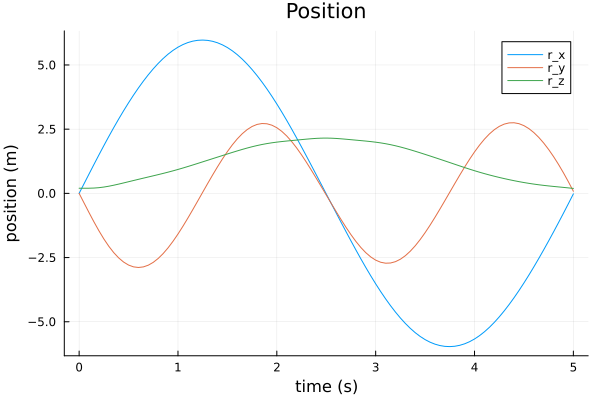

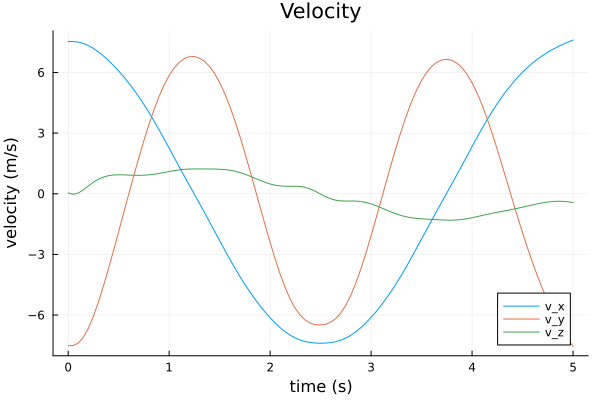

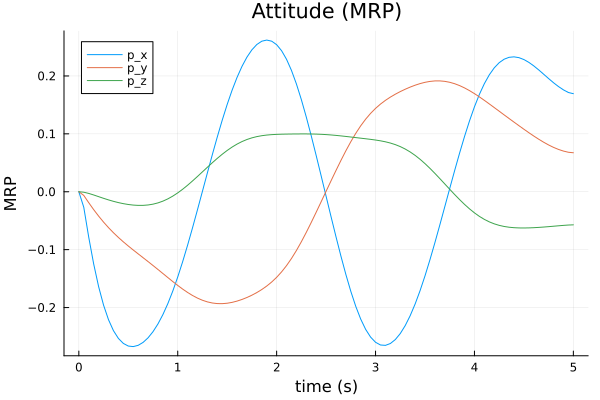

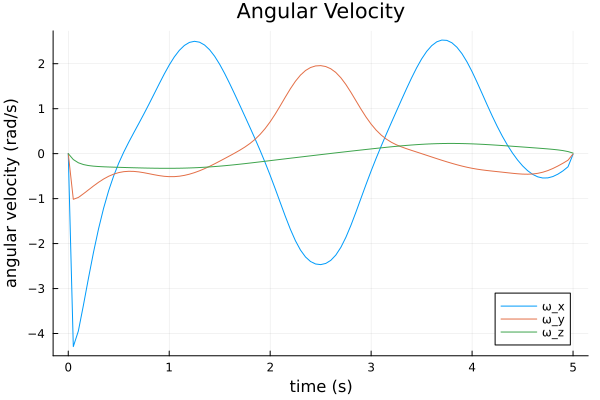

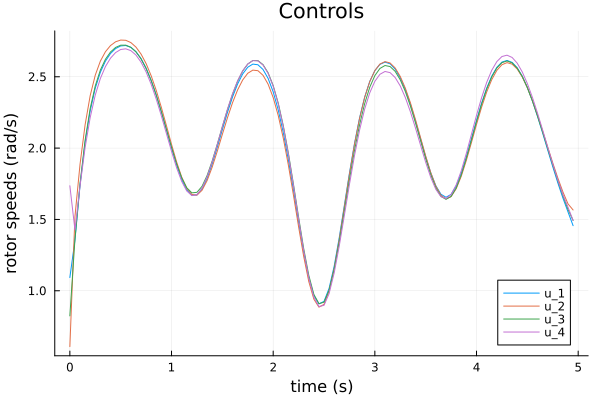

┌ Info: iLQR converged
└ @ Main c:\Users\faust\Desktop\optimal_ctrl_25\HW3_S25_Solutions\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sZmlsZQ==.jl:41
┌ Info: Listening on: 127.0.0.1:8703, thread id: 1
└ @ HTTP.Servers C:\Users\faust\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat C:\Users\faust\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "target" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x74, 0x61, 0x72, 0x67, 0x65, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8703, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8703), "127.0.0.

Test Summary: | Pass  Total     Time
ilqr          |    1      1  1m20.1s


Test.DefaultTestSet("ilqr", Any[], 1, false, false, true, 1.740007329361e9, 1.740007409421e9, false, "c:\\Users\\faust\\Desktop\\optimal_ctrl_25\\HW3_S25_Solutions\\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl")

In [6]:
@testset "ilqr" begin 

    # NOTE: set verbose to true here when you submit
    Xilqr, Uilqr, Kilqr, t_vec, params =  solve_quadrotor_trajectory(verbose = true)
    
    # ---------------testing------------------
    Usol = load(joinpath(@__DIR__,"utils","ilqr_U.jld2"))["Usol"]
    @test maximum(norm.(Usol .- Uilqr,Inf)) <= 1e-2 
    
    # ---------------plotting------------------
    Xm = hcat(Xilqr...)
    Um = hcat(Uilqr...)
    display(plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
                                   title = "Position", label = ["r_x" "r_y" "r_z"]))
    display(plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                                   title = "Velocity", label = ["v_x" "v_y" "v_z"]))
    display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
                                   title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
    display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
                                   title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))
    display(plot(t_vec[1:end-1], Um', xlabel = "time (s)", ylabel = "rotor speeds (rad/s)",
                                   title = "Controls", label = ["u_1" "u_2" "u_3" "u_4"]))
    display(animate_quadrotor(Xilqr, params.Xref, params.model.dt))
end

## Part B: Tracking solution with TVLQR (5 pts)

Here we will do the same thing we did in Q1 where we take a trajectory from a trajectory optimization solver, and track it with TVLQR to account for some model mismatch. In DIRCOL, we had to explicitly compute the TVLQR control gains, but in iLQR, we get these same gains out of the algorithmn as the K's. Use these to track the quadrotor through this manuever. 

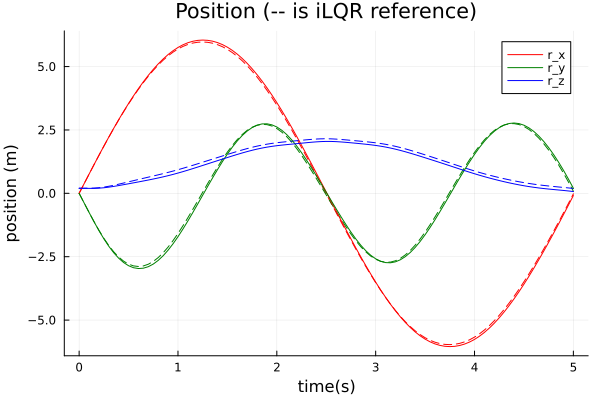

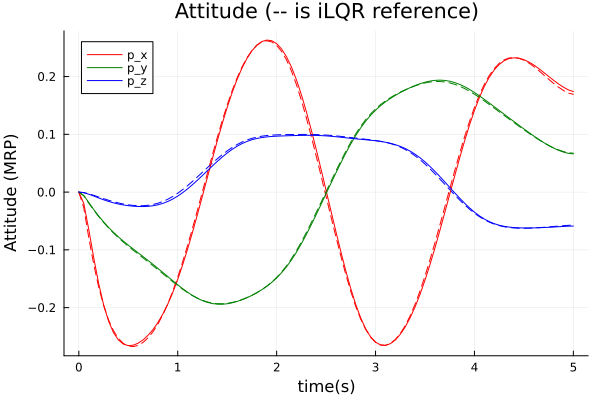

┌ Info: Listening on: 127.0.0.1:8704, thread id: 1
└ @ HTTP.Servers C:\Users\faust\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat C:\Users\faust\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "target" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x74, 0x61, 0x72, 0x67, 0x65, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8704, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8704), "127.0.0.

Test Summary:         | Pass  Total  Time
iLQR with model error |    2      2  1.8s


Test.DefaultTestSet("iLQR with model error", Any[], 2, false, false, true, 1.740007411017e9, 1.740007412847e9, false, "c:\\Users\\faust\\Desktop\\optimal_ctrl_25\\HW3_S25_Solutions\\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl")

In [7]:
@testset "iLQR with model error" begin 

    # set verbose to false when you submit 
    Xilqr, Uilqr, Kilqr, t_vec, params =  solve_quadrotor_trajectory(verbose = false)
    
    # real model parameters for dynamics 
    model_real = (mass=0.5,
            J=Diagonal([0.0025, 0.002, 0.0045]),
            gravity=[0,0,-9.81],
            L=0.1550,
            kf=0.9,
            km=0.0365,dt = 0.05)
    
    # simulate closed loop system 
    nx, nu, N = params.nx, params.nu, params.N
    Xsim = [zeros(nx) for i = 1:N]
    Usim = [zeros(nx) for i = 1:(N-1)]
    
    # initial condition 
    Xsim[1] = 1*Xilqr[1]
    
    # TODO: simulate with closed loop control 
    for i = 1:(N-1) 
        Δx = Xsim[i] - Xilqr[i]
        Δu = -Kilqr[i]*Δx 
        Usim[i] = Uilqr[i] + Δu 
        Xsim[i+1] = rk4(model_real, quadrotor_dynamics, Xsim[i], Usim[i], model_real.dt)
    end
    
    
    # -----------------testing---------------------
    @test 1e-6 <= norm(Xilqr[50] - Xsim[50],Inf) <= .3
    @test 1e-6 <= norm(Xilqr[end] - Xsim[end],Inf) <= .3
    
    # -----------------plotting---------------------
    Xm = hcat(Xsim...)
    Um = hcat(Usim...)
    Xilqrm = hcat(Xilqr...)
    Uilqrm = hcat(Uilqr...)
    plot(t_vec,Xilqrm[1:3,:]',ls=:dash, label = "",lc = [:red :green :blue])
    display(plot!(t_vec,Xm[1:3,:]',title = "Position (-- is iLQR reference)",
                 xlabel = "time(s)", ylabel = "position (m)",
                 label = ["r_x" "r_y" "r_z"],lc = [:red :green :blue]))
    
    plot(t_vec,Xilqrm[7:9,:]',ls=:dash, label = "",lc = [:red :green :blue])
    display(plot!(t_vec,Xm[7:9,:]',title = "Attitude (-- is iLQR reference)",
                 xlabel = "time(s)", ylabel = "Attitude (MRP)",
                 label = ["p_x" "p_y" "p_z"],lc = [:red :green :blue]))
    
    display(animate_quadrotor(Xilqr, params.Xref, params.model.dt))
end